In [3]:
# Import Libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import random

In [4]:
#Class Labels
labels_ = [ 
            'Speed limit (30km/h)', 
            'Speed limit (50km/h)', 
            'Speed limit (120km/h)', 
            'No passing', 
            'No passing veh over 3.5 tons', 
            'Priority road', 
            'Yield', 
            'Stop', 
            'No entry', 
            'Turn right ahead', 
            'Turn left ahead', 
            'Go straight or right', 
            'Go straight or left', 
]

In [5]:
#Defining function for plotting confusion matrix with Seaborn library
from sklearn.metrics import confusion_matrix

def conf_matrix(pred_labels, y_test):
    conf_mat = confusion_matrix(y_test,pred_labels)
    fig, ax = plt.subplots(figsize=(20,15))
    sn.heatmap(conf_mat, annot=True, fmt='d',xticklabels=labels_, yticklabels=labels_)
    plt.ylabel('Actual') 
    plt.yticks(rotation=0) 
    plt.xlabel('Predicted')
    plt.show()

In [6]:
### To test whether GPU instance is present in the system of not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

Using PyTorch version: 1.10.1+cu102 CUDA: True


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
torch.manual_seed(60)
torch.cuda.manual_seed_all(60)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(60)

In [9]:
#Parameters
learning_rate = 0.001
batch_size = 128 
num_epochs = 6

In [10]:
image_size = (32,32)

transformations = transforms.Compose(
        [transforms.Resize(list(image_size)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5], std=[0.5])])

In [14]:
train_set = datasets.ImageFolder('Train_reduced', transform = transformations)

In [15]:
train_set, val_set = torch.utils.data.random_split(train_set, [17000, 219])

In [16]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)

In [17]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)

In [18]:
# Get input/output from data loader
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

print(len(train_loader)*batch_size)

X_train: torch.Size([128, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([128]) type: torch.LongTensor
17024


In [19]:
# Get input/output from data loader
for (X_train, y_train) in val_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())    
    break
print(len(val_loader)*batch_size)

X_train: torch.Size([128, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([128]) type: torch.LongTensor
256


In [20]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        # Dropout to avoid overfitting
        self.drop_out = nn.Dropout()

        # Fully connected layers
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 13)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # Flatten
        out = out.view(out.size(0), -1)

        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [27]:
#Train Function
def train(model, train_loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    total_labels = 0
    correct_labels = 0
    for data, target in train_loader:
        data = Variable(data.float())
        target = Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        print(target.size())
        print(output.size())
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        total_labels += target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct_labels += (predicted == target).sum().item() 

    return data, target, output, total_loss/len(train_loader.dataset), correct_labels, total_labels

#Validation Function
def validation(model, val_loader, loss_fn):
    model.eval()
    total_loss = 0
    total_labels = 0
    correct_labels = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = Variable(images.float())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs,labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_labels += labels.size(0)
            correct_labels += (predicted == labels).sum().item()
    
    
    return images, labels, outputs, total_loss/len(val_loader.dataset), correct_labels, total_labels

#Test Function
def test(model, test_loader):
    model.eval()
    total_labels = 0
    correct_labels = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = Variable(images.float())
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_labels += labels.size(0)
            correct_labels += (predicted == labels).sum().item()
    
    accuracy = 100 *  correct_labels / total_labels

    return images, labels, outputs, accuracy

        

In [28]:
# Declaring the loss function and optimizer
model = CNN()
model = model.to(device)
print(model)

#criterion = # YOUR CODE HERE : Explore and declare loss function
# loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.CrossEntropyLoss().to(device)

#optimizer = # YOUR CODE HERE : Explore on optimizer and define with the learning rate
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear

In [25]:
# Testing Evaluation for CNN model

val_set = datasets.ImageFolder('Test_foldered_reduced',transform = transformations)

# YOUR CODE HERE for the DataLoader
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)

In [29]:
#Training
tr_losses = [] 
val_losses = []

for epoch in range(1,num_epochs +1):
    # train network for 1 epoch
    tr_data, tr_target, tr_output, tr_loss, tr_correct_labels, tr_total_labels = train(model,train_loader, loss_fn, optimizer)
    # Validate the network on validation dataset
    val_data, val_target, val_output, val_loss, val_correct_labels, val_total_labels = validation(model,val_loader, loss_fn)

    tr_accuracy = 100 *  tr_correct_labels / tr_total_labels
    val_accuracy = 100 * val_correct_labels / val_total_labels

    #log
    print('epoch [{}/{}], loss train:{:.6f} loss validation:{:.6f}, train accuracy:{:.6f}, validation accuracy:{:.6f}'
            .format(epoch, num_epochs, tr_loss, val_loss, tr_accuracy, val_accuracy))

    #Save Loss values
    tr_losses.append(tr_loss)
    val_losses.append(val_loss)


torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])
torch.Size([128])
torch.Size([128, 13])


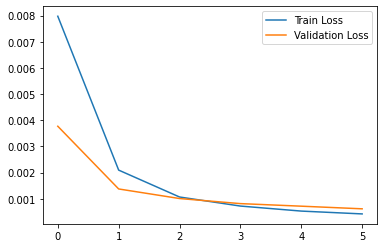

In [41]:
plt.figure()
plt.plot(tr_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()


In [42]:
torch.save(model, 'conv_net_model.pth')

In [43]:
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear

In [19]:
# Load the model
loaded_model = torch.load('conv_net_model.pth',map_location=device)
loaded_model


CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear

In [20]:
val_data, val_target, val_output, accuracy = test(loaded_model,val_loader)

    
accuracy

97.95008912655972

In [21]:
print('{:.6f}'.format(accuracy))

97.950089


In [22]:
# YOUR CODE HERE for calculating the accuracy
loaded_model.eval()

loaded_model = model.eval()

correct = 0
total = 0

#Initalize empty tensor for storing predictions
predicted_np = torch.empty(0)

#Initialize empty tensor for storing labels from test data
test_labels_np = torch.empty(0)

#Transfer empty tensor to "device" (to CUDA if necesaary)
predicted_np , test_labels_np = predicted_np.to(device), test_labels_np.to(device)

for images, labels in val_loader:
    images = Variable(images.float())
    images, labels = images.to(device), labels.to(device)
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs.data, 1)
    predicted_np = torch.concat((predicted_np,predicted))
    test_labels_np = torch.concat((test_labels_np,labels))
    total += labels.size(0)
    correct += (predicted == labels).sum()

#Transfer tensors with label, to cpu and convert to numpy arrays for further processings.
predicted_np = predicted_np.cpu().numpy()
test_labels_np = test_labels_np.cpu().detach().numpy()
print('Test Accuracy of the model on test images: %.6f %%' % (100 * correct / total))

Test Accuracy of the model on test images: 97.950089 %


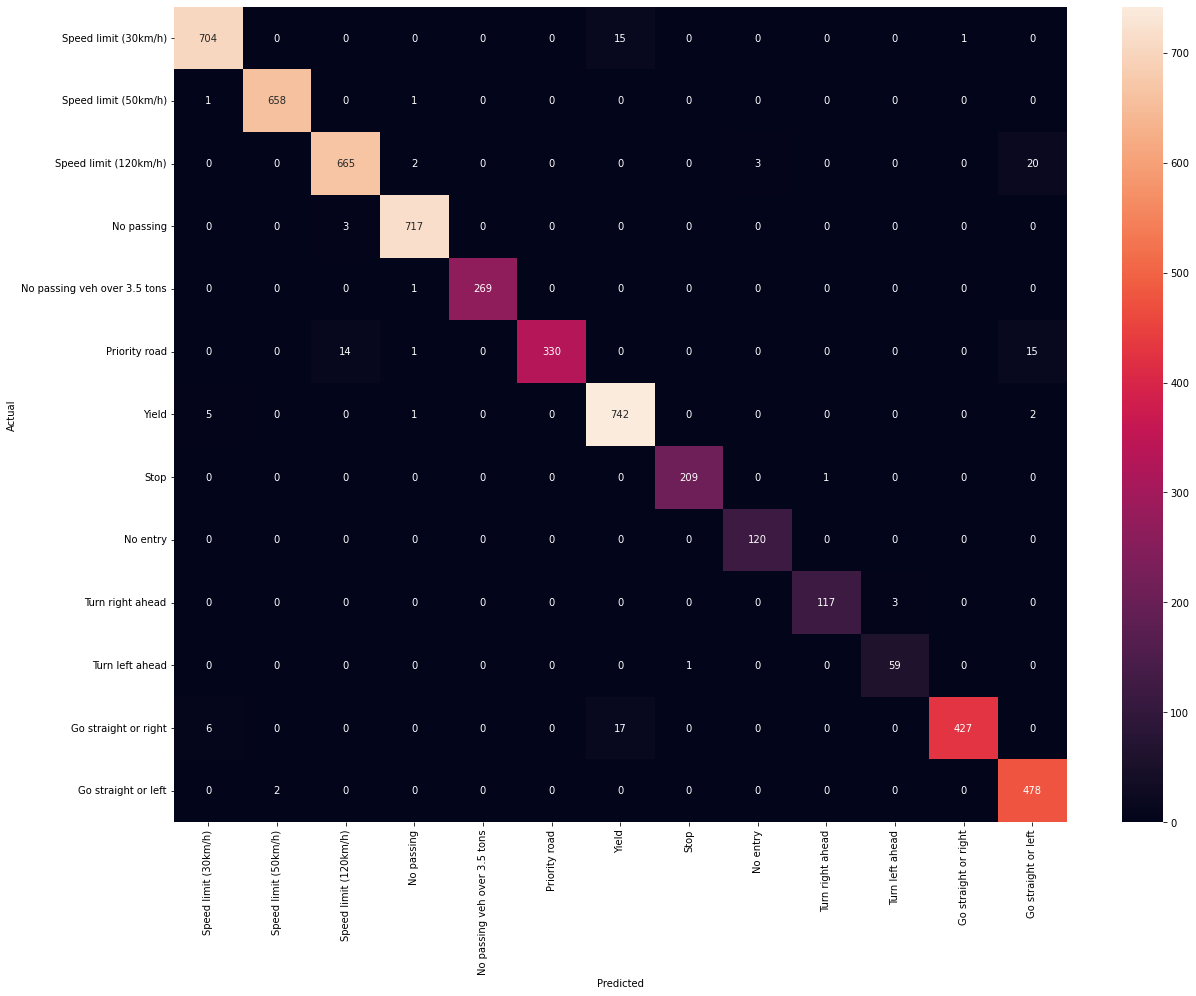

In [23]:
conf_matrix(predicted_np,test_labels_np)

100 EPOCH

In [24]:
# Declaring the loss function and optimizer

model = CNN()
model = model.to(device)
print(model)

#criterion = # YOUR CODE HERE : Explore and declare loss function
# loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.CrossEntropyLoss()

#optimizer = # YOUR CODE HERE : Explore on optimizer and define with the learning rate
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear

In [25]:
# %%time
# epochs = 100
# lossv, accv = [], []
# for epoch in range(1, epochs+1):
#     train(epoch)
#     # test(lossv, accv)

In [26]:
# # YOUR CODE HERE for calculating the accuracy
# loaded_model.eval()

# loaded_model = model.eval()

# correct = 0
# total = 0

# #Initalize empty tensor for storing predictions
# predicted_np = torch.empty(0)

# #Initialize empty tensor for storing labels from test data
# test_labels_np = torch.empty(0)

# #Transfer empty tensor to "device" (to CUDA if necesaary)
# predicted_np , test_labels_np = predicted_np.to(device), test_labels_np.to(device)

# for images, labels in test_loader:
#     images = Variable(images.float())
#     images, labels = images.to(device), labels.to(device)
#     outputs = loaded_model(images)
#     _, predicted = torch.max(outputs.data, 1)
#     predicted_np = torch.concat((predicted_np,predicted))
#     test_labels_np = torch.concat((test_labels_np,labels))
#     total += labels.size(0)
#     correct += (predicted == labels).sum()

# #Transfer tensors with label, to cpu and convert to numpy arrays for further processings.
# predicted_np = predicted_np.cpu().numpy()
# test_labels_np = test_labels_np.cpu().detach().numpy()
# print('Test Accuracy of the model on test images: %.4f %%' % (100 * correct / total))

In [27]:
import torch
  
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device: 0
Name of current CUDA device:GeForce GTX 1050 Ti


In [28]:
torch.backends.cudnn.version()

8200